# Project 3
## Tasks 1 and 2

Task 1 was simply to install torch and torchvision, which was trivial. The rest of this section covers Task 2.

I mostly stuck to the code in the tutorial, since it does the job and is already written. But I'll go ahead and explain what is happening in each block to show that I am not just being lazy.

This next section is just setting up the imports for the task and loading the training and test data using the built-in functions for the FashionMNIST dataset. I didn't go through MNIST number set, since I have already analyzed those data using keras and tensorflow in previous workshops. The FashionMNIST set was much more interesting to me.

In [1]:
import torch

from numpy.random import default_rng
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
from tqdm.notebook import trange

import matplotlib.pyplot as plt
import numpy as np

# custom function imports
from task2_functions import CNeuralNetwork, NeuralNetwork, train, test, explore_wrong_5x5


training_data = datasets.FashionMNIST(root="data",
                                      train=True,
                                      download=True,
                                      transform=ToTensor())

test_data = datasets.FashionMNIST(root="data",
                                      train=False,
                                      download=True,
                                      transform=ToTensor())

I wrote this next section just to explore the data a bit. It grabs a random image and displays it.

Ankle boot


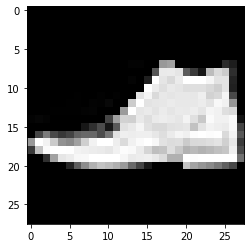

In [2]:
# Run this to explore random data

rng = default_rng()
slct = rng.integers(training_data.data.shape[0])

plt.imshow(training_data.data[slct], cmap='gray');
print(training_data.classes[training_data.targets[slct]])

This next block comes from the tutorial. It is demonstrating how you can instantiate a DataLoader object by using just a Dataset and specifying batch_size. The code prints some basic info about the output tensor.

In [3]:
batch_size = 64

# Create data loaders.
train_dataloader = DataLoader(training_data, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

# This is written this way to show the form of the loop.
# X is a batch of data
# y is the labels for the data
for X, y in test_dataloader:
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break

Shape of X [N, C, H, W]: torch.Size([64, 1, 28, 28])
Shape of y: torch.Size([64]) torch.int64


The next block is showing that I have cuda available and setting my device to cuda. I am doing this assignment on a fairly powerful desktop with an NVIDA Quadro RTX 5000.

In [4]:
# Verify that cuda is available

device = "cuda"  # If cuda is available!
torch.cuda.is_available()

True

Here I am moving the neural network from the tutorial to the GPU and printing its architecture. It's a basic fully connected network with a couple of hidden layers.

In [5]:
model = NeuralNetwork().to(device)  
print(model)

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)


For training this network, I use a cross entropy loss function, which is common for classification tasks and what is what the tutorial suggests. I use stochastic gradient descent to tune the model's parameters, with a learning rate of 0.001, as the tutorial suggests.

In [6]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)  # Stochastic Gradient Descent

Training is using functions mostly copied from the tutorial, with some tweaks to be less chatty. I am also using `tqdm` with jupyter widgets to produce a nice progress bar. This won't show up nicely in the pdf output.

The `train` and `test` functions here are pretty similar to one another in that they are just running the model over data, except `train` runs the model in "train" mode and adjusts model weights (train mode will also configure certain layers to, e.g., dropout some elements as part of training), whereas `test` runs the model in "eval" mode, which just computes the output layer without adjusting weights (or, e.g., dropping out elements). Of course the `train` function also differs in that it is adjusting model parameters with the optimizer.

Both functions take the dataloaders, model, and loss function object as parameters. `train` also takes the configured optimizer because that is what is used to adjust the model parameters during training.

In [7]:
# This ran at about 7s per epoch

epochs = 15
for t in trange(epochs):
    train(device, train_dataloader, model, loss_fn, optimizer)
    test(device, test_dataloader, model, loss_fn)

  0%|          | 0/15 [00:00<?, ?it/s]

Test Error: 
 Accuracy: 52.5%, Avg loss: 2.167878 

Test Error: 
 Accuracy: 55.9%, Avg loss: 1.919303 

Test Error: 
 Accuracy: 59.6%, Avg loss: 1.561911 

Test Error: 
 Accuracy: 63.0%, Avg loss: 1.289035 

Test Error: 
 Accuracy: 64.4%, Avg loss: 1.117482 

Test Error: 
 Accuracy: 65.8%, Avg loss: 1.005830 

Test Error: 
 Accuracy: 67.1%, Avg loss: 0.928863 

Test Error: 
 Accuracy: 68.0%, Avg loss: 0.872987 

Test Error: 
 Accuracy: 69.2%, Avg loss: 0.830669 

Test Error: 
 Accuracy: 70.3%, Avg loss: 0.797315 

Test Error: 
 Accuracy: 71.6%, Avg loss: 0.769970 

Test Error: 
 Accuracy: 72.5%, Avg loss: 0.746777 

Test Error: 
 Accuracy: 73.5%, Avg loss: 0.726535 

Test Error: 
 Accuracy: 74.1%, Avg loss: 0.708463 

Test Error: 
 Accuracy: 75.0%, Avg loss: 0.692085 



I wrote a function to explore the "wrong" guesses from the model, to better understand why the model might be failing. It grabs 25 random wrong-guess images from a dataset and prints the model guess against ground truth for each. It's not very efficient but it works.

In many cases, I would argue that the guesses are pretty close, if not better than ground truth (e.g., pullover vs shirt). So this model is pretty good, even though the formal accuracy is only converges to 75-80%. It would be interesting to see what the agreement between two humans would be for a given item.

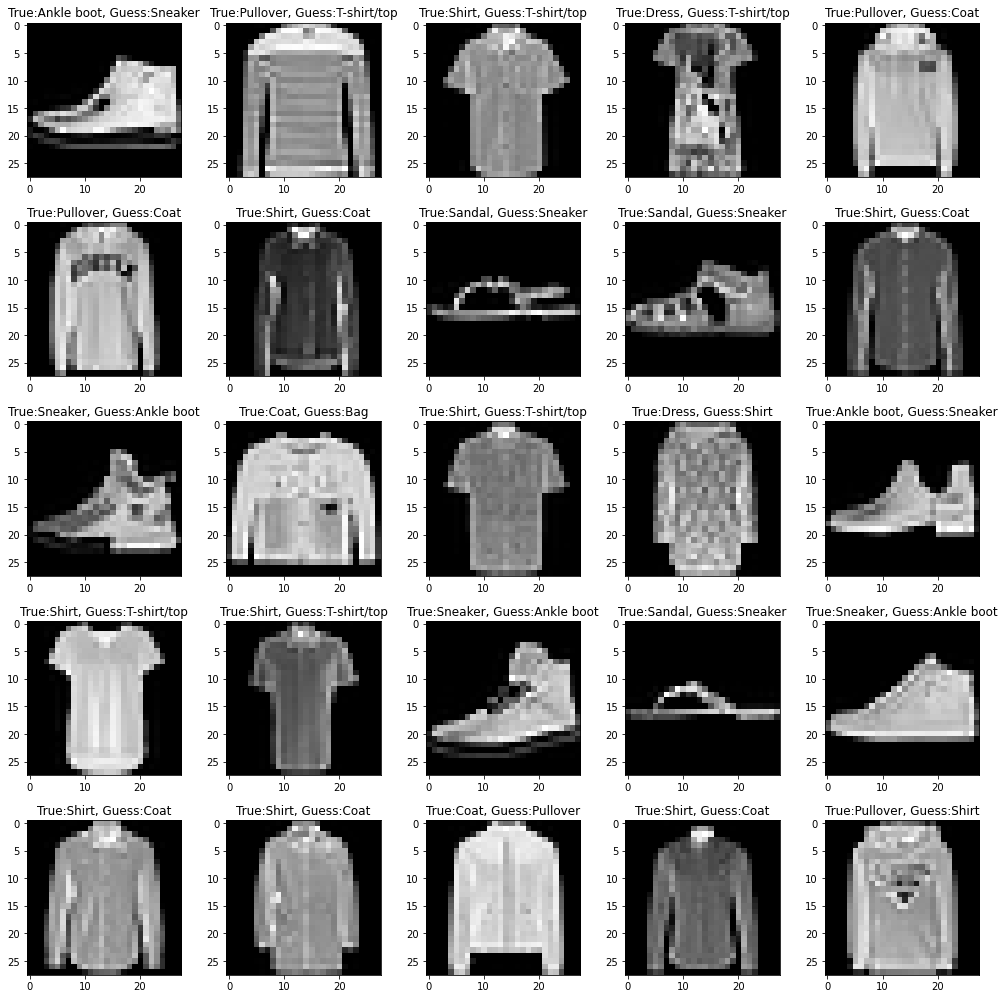

In [8]:
# Run this to explore random wrong answers

explore_wrong_5x5(train_dataloader, model, device, class_labels=training_data.classes, seed=90210)

I tried creating a better model using a convolutional neural network approach. I mostly played around with parameters until I got something that converged. This model not only converged, but it outperformed the example model:

In [9]:
# Define model
model2 = CNeuralNetwork().to(device)  
print(model2)

CNeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (conv_stack): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), padding_mode=reflect)
    (1): ReLU()
    (2): Conv2d(16, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), padding_mode=reflect)
    (3): ReLU()
    (4): Conv2d(256, 512, kernel_size=(7, 7), stride=(1, 1), padding=(1, 1), padding_mode=reflect)
    (5): MaxPool2d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
  )
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=512, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)


In [10]:
# This ran about 17s per epoch

optimizer = torch.optim.SGD(model2.parameters(), lr=1e-3)  # Stochastic Gradient Descent

epochs = 25
for t in trange(epochs):
    train(device, train_dataloader, model2, loss_fn, optimizer)
    test(device, test_dataloader, model2, loss_fn)

  0%|          | 0/25 [00:00<?, ?it/s]

Test Error: 
 Accuracy: 28.1%, Avg loss: 2.299297 

Test Error: 
 Accuracy: 28.9%, Avg loss: 2.294930 

Test Error: 
 Accuracy: 29.9%, Avg loss: 2.288606 

Test Error: 
 Accuracy: 31.2%, Avg loss: 2.278090 

Test Error: 
 Accuracy: 34.0%, Avg loss: 2.257517 

Test Error: 
 Accuracy: 45.1%, Avg loss: 2.203660 

Test Error: 
 Accuracy: 51.1%, Avg loss: 1.981466 

Test Error: 
 Accuracy: 55.3%, Avg loss: 1.311038 

Test Error: 
 Accuracy: 65.5%, Avg loss: 1.002085 

Test Error: 
 Accuracy: 69.6%, Avg loss: 0.877546 

Test Error: 
 Accuracy: 72.6%, Avg loss: 0.795338 

Test Error: 
 Accuracy: 74.4%, Avg loss: 0.735811 

Test Error: 
 Accuracy: 75.3%, Avg loss: 0.694799 

Test Error: 
 Accuracy: 76.1%, Avg loss: 0.665761 

Test Error: 
 Accuracy: 76.7%, Avg loss: 0.643470 

Test Error: 
 Accuracy: 77.6%, Avg loss: 0.625177 

Test Error: 
 Accuracy: 78.0%, Avg loss: 0.609068 

Test Error: 
 Accuracy: 78.6%, Avg loss: 0.594089 

Test Error: 
 Accuracy: 79.3%, Avg loss: 0.579933 

Test Error: 

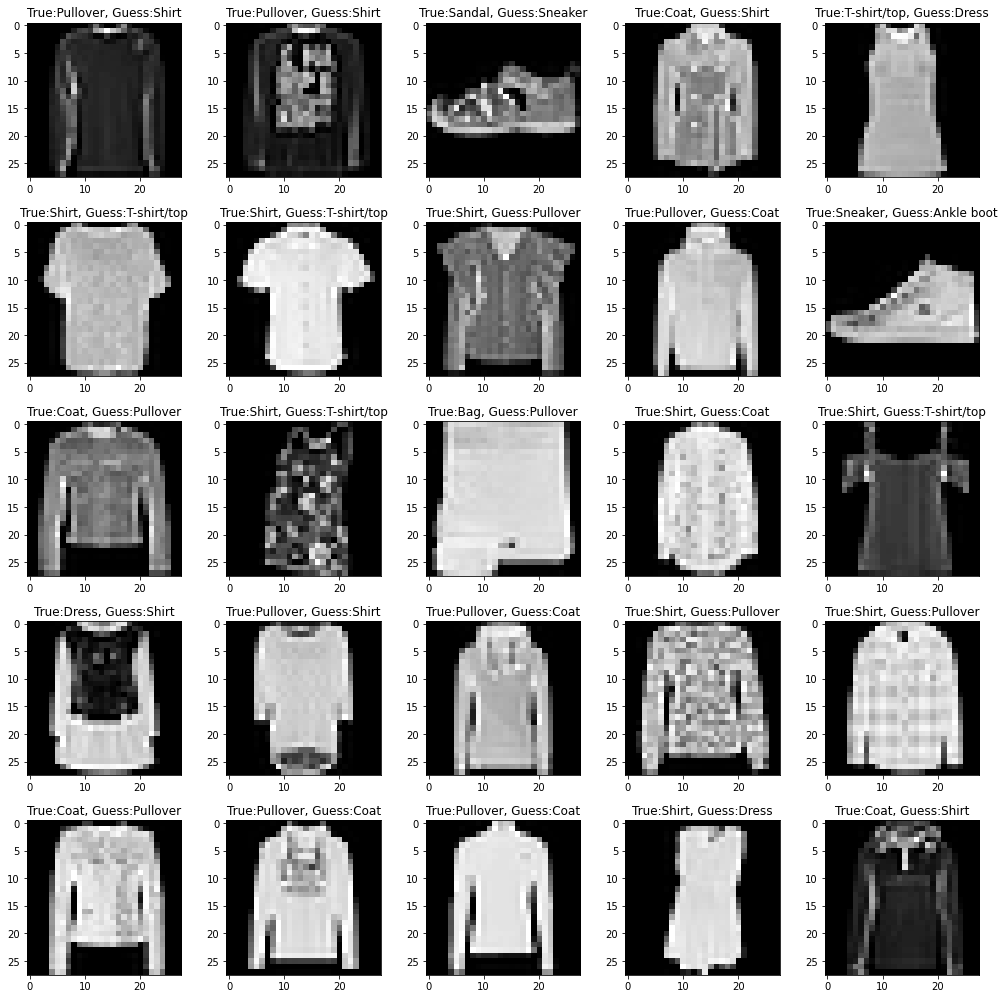

In [11]:
explore_wrong_5x5(train_dataloader, model2, device, class_labels=training_data.classes, seed=90210)

In [12]:
torch.save(model2, 'models/mycnn')

The best run of my CNN model is here:

In [13]:
model3 = torch.load('models/mycnn_best')
test(device, test_dataloader, model3, loss_fn)

Test Error: 
 Accuracy: 81.3%, Avg loss: 0.508019 



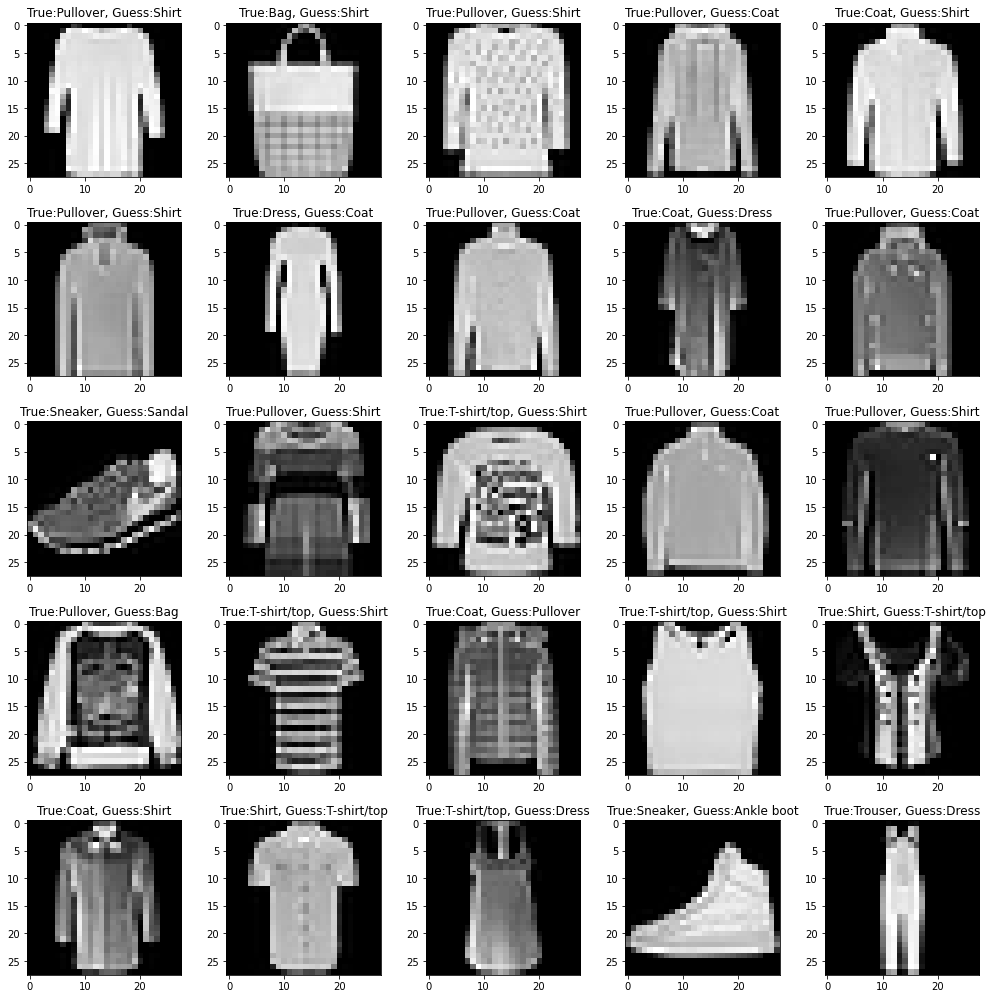

In [14]:
explore_wrong_5x5(train_dataloader, model3, device, class_labels=training_data.classes, seed=12345)

All in all, this wasn't a terrible model. I could have improved it by playing with the model parameters, or trying some more complicated architectures.

## Appendix

### task2_functions.py

```python

import torch
import matplotlib.pyplot as plt
from torch import nn
from numpy.random import default_rng

# class definitions
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10)
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits
    

class CNeuralNetwork(nn.Module):
    def __init__(self):
        super(CNeuralNetwork, self).__init__()
        self.flatten = nn.Flatten()
        self.conv_stack = nn.Sequential(
            nn.Conv2d(1, 16, 3, stride=2, padding=1, padding_mode='reflect'),
            nn.ReLU(),
            nn.Conv2d(16, 256, 3, stride=2, padding=1, padding_mode='reflect'),
            nn.ReLU(),
            nn.Conv2d(256, 512, 7, stride=1, padding=1, padding_mode='reflect'),
            nn.MaxPool2d(3),
        )
        
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10)
        )

    def forward(self, x):
        x = self.conv_stack(x)
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits
    

# Convenience functions
def train(device, dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
            

def test(device, dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

    
@torch.no_grad()
def explore_wrong_5x5(dataloader, model, device, class_labels=None, seed=None, replace=False):
    model.eval()
    rng = default_rng(seed)
    all_wrong = torch.empty(0, dtype=torch.int64, device=device)
    preds = torch.empty(0, dtype=torch.int64, device=device)
    gtruths = torch.empty(0, dtype=torch.int64, device=device)
    for X, y in dataloader:
        X, y = X.to(device), y.to(device)
        pred = model(X).argmax(1)
        wrong = pred != y
        wrong_ixs = torch.argwhere(wrong).flatten()
        for ix in wrong_ixs:
            all_wrong = torch.cat((all_wrong, X[ix, ...]))
            preds = torch.cat((preds, torch.tensor([pred[ix]]).to(device)))
            gtruths = torch.cat((gtruths, torch.tensor([y[ix]]).to(device)))
    
    example_ixs = rng.choice(range(len(gtruths)), 25, replace=replace)
    
    fig, axes = plt.subplots(nrows=5, ncols=5, figsize=(14, 14))
    fig.tight_layout()
    for i, ix in enumerate(example_ixs):
        X = all_wrong[ix]
        y = gtruths[ix]
        y_guess = preds[ix]
        if class_labels:
            true = class_labels[y]
            guess = class_labels[y_guess]
        else:
            true = str(int(y))
            guess = str(int(y_guess))
        ax = axes.flatten()[i]
        ax.set_title(f'True:{true}, Guess:{guess}')
        im = X.squeeze().cpu()
        
        ax.imshow(im, cmap='gray')
    model.train()

```